### Phase1: Collecting required Package and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score


In [2]:
data = pd.read_csv("C:/Users/Mohan/Documents/___.__/Project/EURINR.csv")

### Phase2: Preprocessing

In [3]:
data['Date'] = pd.to_datetime(data["Date"], format='%d/%m/%Y %H:%M:%S')
# data= data.set_index(["Date"], drop=False)

In [4]:
data['Date']=data.Date.apply(lambda x: str(x).split(" ")[0])

In [5]:
data['Date'] = pd.to_datetime(data['Date'])

<AxesSubplot: >

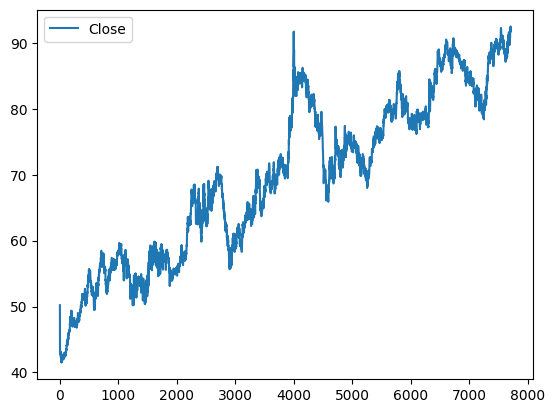

In [6]:
data.plot(y='Close')

In [7]:
data['Date'].sort_values()

0      2002-01-01
1      2002-01-02
2      2002-01-03
3      2002-01-04
4      2002-01-05
          ...    
7710   2023-12-27
7711   2023-12-28
7712   2023-12-29
7713   2023-12-30
7714   2023-12-31
Name: Date, Length: 7715, dtype: datetime64[ns]

In [8]:
data.head()

,Date,Close
0,2002-01-01,50.20400
1,2002-01-02,43.60000
2,2002-01-03,43.20000
3,2002-01-04,43.13900
4,2002-01-05,43.09701


In [9]:
data.tail()

,Date,Close
7710,2023-12-27,92.4960
7711,2023-12-28,91.9765
7712,2023-12-29,91.8660
7713,2023-12-30,92.1420
7714,2023-12-31,91.8690


In [10]:
data.describe()

,Close
count,7715.000000
mean,69.628066
std,12.606973
min,41.511000
25%,57.868500
50%,70.217000
75%,80.216000
max,92.496000


In [11]:
split_date = pd.Timestamp('01-01-2019')

test = data[data['Date']>=split_date]
train = data[data['Date']<split_date]
print(len(train),len(test))


5889 1826


In [12]:
train=train.drop(['Date'],axis=1)
test=test.drop(['Date'],axis=1)

In [13]:

sc = MinMaxScaler()
train = sc.fit_transform(train)
test = sc.transform(test)

In [14]:
train=pd.DataFrame(train)
test=pd.DataFrame(test)

### Phase3: LSTM layer

In [15]:
# Define and train LSTM model
def create_lstm_model(input_shape):
    look_back = 10
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))  # Hyperparameter: Number of LSTM units
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def train_lstm_model(train_data):
    X_train, y_train = [], []
    for i in range(len(train_data)-11):
        X_train.append(train_data.iloc[i:i+10])
        y_train.append(train_data.iloc[i+11])
    X_train, y_train = np.array(X_train), np.array(y_train)
    print(X_train.shape,y_train.shape)
    model = create_lstm_model(X_train.shape[1:])
    model.summary()
    model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=0)
    
    return model

lstm_model = train_lstm_model(train)




(5878, 10, 1) (5878, 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



In [16]:
# Make predictions using LSTM model
def lstm_forecast(model, test_data):
    X_test, y_test = [], []
    for i in range(len(test_data)-11):
        X_test.append(test_data.iloc[i:i+10])
        y_test.append(test_data.iloc[i+11])
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    y_pred = model.predict(X_test, verbose=0)
    return y_pred, y_test

lstm_predictions, y_test = lstm_forecast(lstm_model,test)

In [17]:
lstm_predictions

array([[0.7798616 ],
       [0.7780336 ],
       [0.7788676 ],
       ...,
       [0.98018146],
       [0.9722691 ],
       [0.97262603]], dtype=float32)

In [18]:
y_test

array([[0.77980281],
       [0.77980281],
       [0.78860671],
       ...,
       [1.00298775],
       [1.00848521],
       [1.00304751]])

### Phase4: ARIMA layer

In [19]:
# Calculate residuals (difference between actual values and LSTM predictions)
residuals = y_test - lstm_predictions

# Train ARIMA model on residuals
arima_model = ARIMA(residuals, order=(5,1,0))
arima_model_fit = arima_model.fit()

# Make predictions using ARIMA model
arima_predictions = arima_model_fit.forecast(steps=len(y_test))
arima_predictions=arima_predictions.reshape(-1,1)
# Combine forecasts from LSTM and ARIMA
hybrid_forecast = lstm_predictions + arima_predictions

In [20]:
lstm_predictions.shape

(1815, 1)

In [21]:
arima_predictions.shape

(1815, 1)

In [22]:
hybrid_forecast.shape

(1815, 1)

In [23]:
mae_lstm = mean_absolute_error(lstm_predictions,y_test)
mae_arima =mean_absolute_error(arima_predictions, y_test)
mae_hybrid =mean_absolute_error(hybrid_forecast,y_test)

mse_lstm = mean_squared_error(lstm_predictions,y_test)
mse_arima =mean_squared_error(arima_predictions, y_test)
mse_hybrid =mean_squared_error(hybrid_forecast,y_test)

rmse_lstm = np.sqrt(mean_squared_error(lstm_predictions,y_test))
rmse_arima =np.sqrt(mean_squared_error(arima_predictions, y_test))
rmse_hybrid =np.sqrt(mean_squared_error(hybrid_forecast,y_test))

r2_lstm = r2_score(lstm_predictions,y_test)
r2_arima =r2_score(arima_predictions, y_test)
r2_hybrid =r2_score(hybrid_forecast,y_test)

### Results and Conclusions

Mean Absolute Error (LSTM)  : 0.013491831167938999
Mean Absolute Error (ARIMA)    : 0.8268157212508
Mean Absolute Error (Hybrid): 0.020203995218287783

Mean Squared Error (LSTM)  : 0.00027868700695818404
Mean Squared Error (ARIMA)    : 0.6907952213522442
Mean Squared Error (Hybrid): 0.0005317284452170504

Root Mean Squared Error (LSTM)  : 0.01669392125769689
Root Mean Squared Error (ARIMA)    : 0.8311409154603353
Root Mean Squared Error (Hybrid): 0.023059237741457336

r2_score (LSTM)  : 0.9524844184146269
r2_score (ARIMA)    : -43704962.76960696
r2_score (Hybrid): 0.9093440364868893


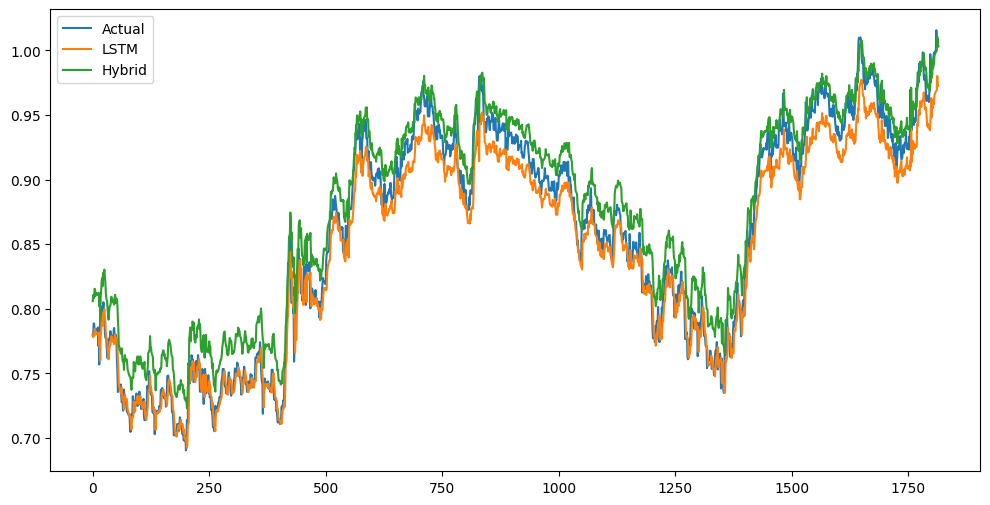

In [24]:

print("Mean Absolute Error (LSTM)  :", mae_lstm)
print("Mean Absolute Error (ARIMA)    :", mae_arima)
print("Mean Absolute Error (Hybrid):", mae_hybrid)
print("")
print("Mean Squared Error (LSTM)  :", mse_lstm)
print("Mean Squared Error (ARIMA)    :", mse_arima)
print("Mean Squared Error (Hybrid):", mse_hybrid)
print("")
print("Root Mean Squared Error (LSTM)  :", rmse_lstm)
print("Root Mean Squared Error (ARIMA)    :", rmse_arima)
print("Root Mean Squared Error (Hybrid):", rmse_hybrid)
print("")
print("r2_score (LSTM)  :", r2_lstm)
print("r2_score (ARIMA)    :", r2_arima)
print("r2_score (Hybrid):", r2_hybrid)

# Plot forecasts
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual')
plt.plot(lstm_predictions, label='LSTM')
#plt.plot(arima_predictions, label='ARIMA')
plt.plot(hybrid_forecast, label='Hybrid')
plt.legend()
plt.show()

In [25]:
final_predictions=np.array(hybrid_forecast)
final_predictions=pd.DataFrame(final_predictions)
final_predictions.to_csv('LSTIM_ARIMA_EURINR.csv', index=False)